<a href="https://colab.research.google.com/github/Marciorochar/Analise-Preditiva/blob/main/Analises_Grafico_Regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [447]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV
import warnings
warnings.filterwarnings('ignore')

In [448]:
# Carregar os dados
df = pd.read_excel("dados_completos_com_dummies_lags.xlsx", sheet_name="Modelo Completo", index_col=0)
df.index = pd.to_datetime(df.index)

In [449]:
# Selecionar lags e variáveis sazonais
lags = [f'lag_{i}' for i in range(1, 11)]
sazonais = [col for col in df.columns if 'dia_da_semana' in col or col in ['mes', 'feriado']]
X = df[lags + sazonais]
y = df['vendas']
X = sm.add_constant(X)
df_model = df.dropna(subset=lags + ['vendas'])

In [450]:
# Rolling OLS
def rolling_ols(y, X, janela=90):
    resultados = []
    for i in range(janela, len(X)):
        X_treino = X.iloc[i - janela:i]
        y_treino = y.iloc[i - janela:i]
        X_teste = X.iloc[i:i+1]
        modelo = sm.OLS(y_treino, X_treino).fit()
        y_pred = modelo.predict(X_teste)
        resultados.append({
            "data": y.index[i],
            "real": y.iloc[i],
            "previsto": y_pred.iloc[0],
            "resíduo": y.iloc[i] - y_pred.iloc[0],
            "r2": modelo.rsquared
        })
    return pd.DataFrame(resultados).set_index("data")

# Aplicar modelo
resultados = rolling_ols(y, X)
resultados.head()

,real,previsto,resíduo,r2
data,,,,
2022-04-16,120,111.951601,8.048399,0.383458
2022-04-17,109,107.371656,1.628344,0.401533
2022-04-18,106,102.006270,3.993730,0.426102
2022-04-19,89,105.832975,-16.832975,0.433153
2022-04-20,100,105.300245,-5.300245,0.423182


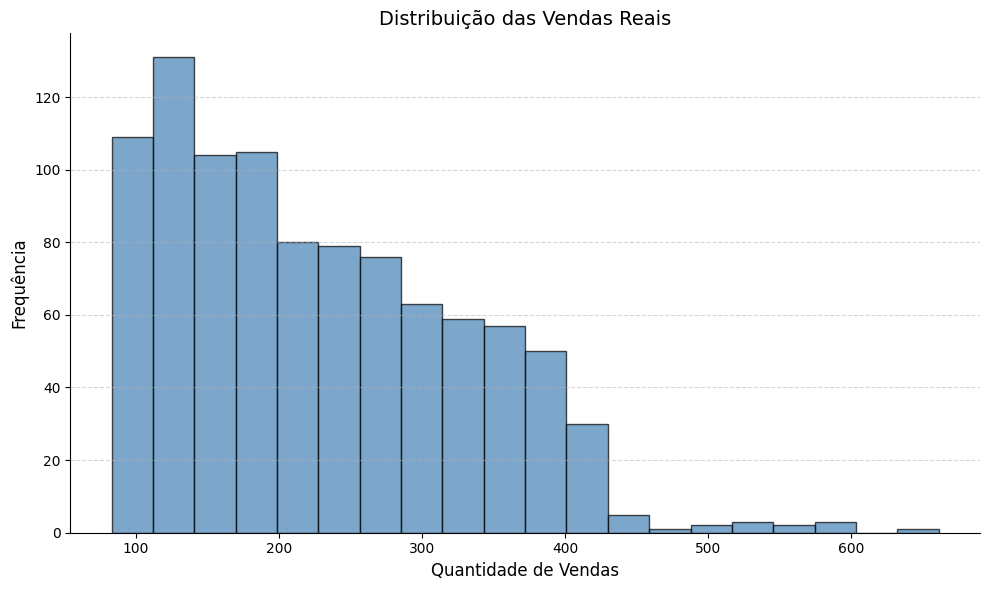

In [451]:
# @title Distribuição das Vendas Reais

import matplotlib.pyplot as plt

# Plotar histograma das vendas reais
plt.figure(figsize=(10, 6))
plt.hist(resultados['real'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)

# Títulos e rótulos
plt.title('Distribuição das Vendas Reais', fontsize=14)
plt.xlabel('Quantidade de Vendas', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Melhorar estilo do gráfico
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()


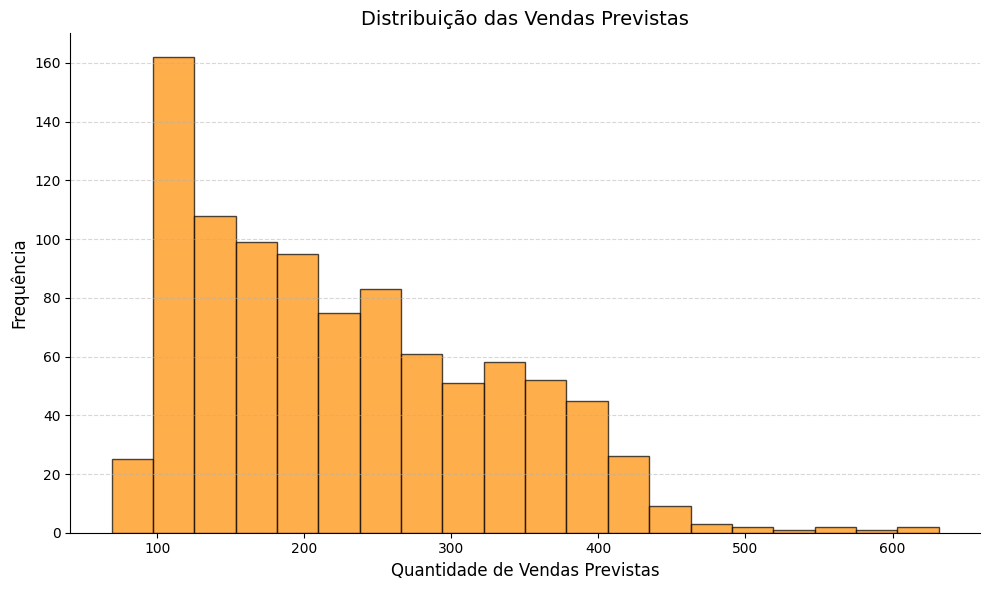

In [452]:
# @title Distribuição das Vendas Previstas
# Plotar histograma das vendas previstas
plt.figure(figsize=(10, 6))
plt.hist(resultados['previsto'], bins=20, color='darkorange', edgecolor='black', alpha=0.7)

# Títulos e rótulos
plt.title('Distribuição das Vendas Previstas', fontsize=14)
plt.xlabel('Quantidade de Vendas Previstas', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Melhorar estilo do gráfico
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()

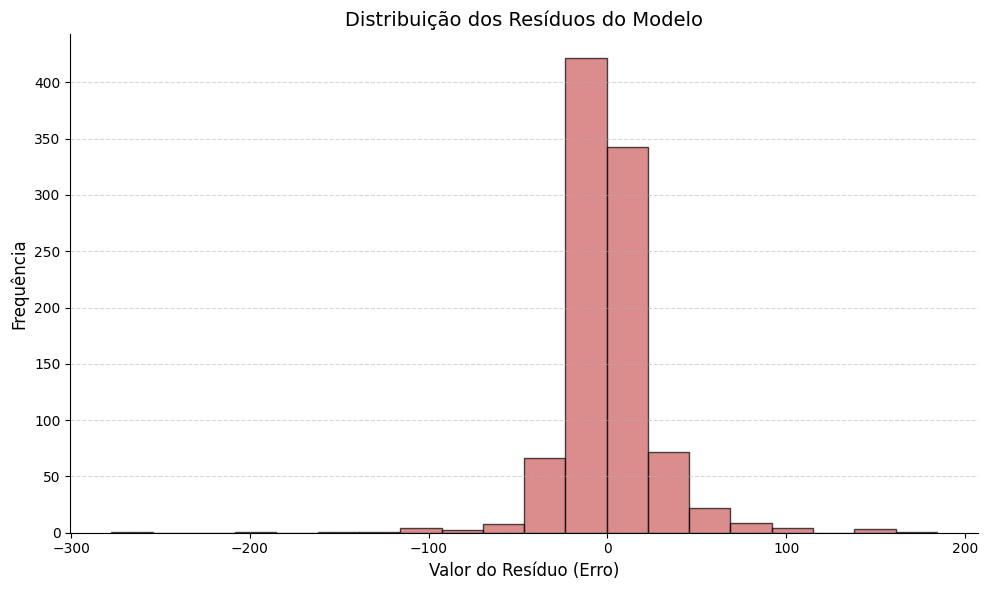

In [453]:
# @title Histograma dos Resíduos

# Plotar histograma dos resíduos
plt.figure(figsize=(10, 6))
plt.hist(resultados['resíduo'], bins=20, color='indianred', edgecolor='black', alpha=0.7)

# Títulos e rótulos
plt.title('Distribuição dos Resíduos do Modelo', fontsize=14)
plt.xlabel('Valor do Resíduo (Erro)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Melhorar estilo do gráfico
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()

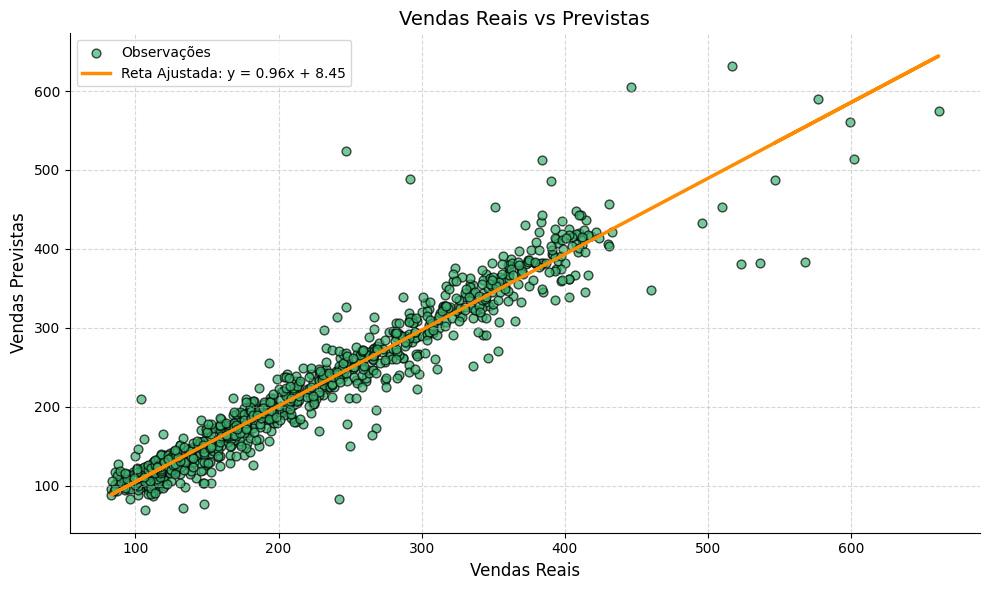

In [454]:
# @title real vs previsto

x = resultados['real']
y = resultados['previsto']

# Ajuste de regressão linear: y = a*x + b
a, b = np.polyfit(x, y, 1)
reta_ajustada = a * x + b

# Gráfico de dispersão com reta ajustada
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=40, alpha=0.7, color='mediumseagreen', edgecolor='black', label='Observações')
plt.plot(x, reta_ajustada, color='darkorange', linewidth=2.5, label=f'Reta Ajustada: y = {a:.2f}x + {b:.2f}')

# Estética
plt.title('Vendas Reais vs Previstas', fontsize=14)
plt.xlabel('Vendas Reais', fontsize=12)
plt.ylabel('Vendas Previstas', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

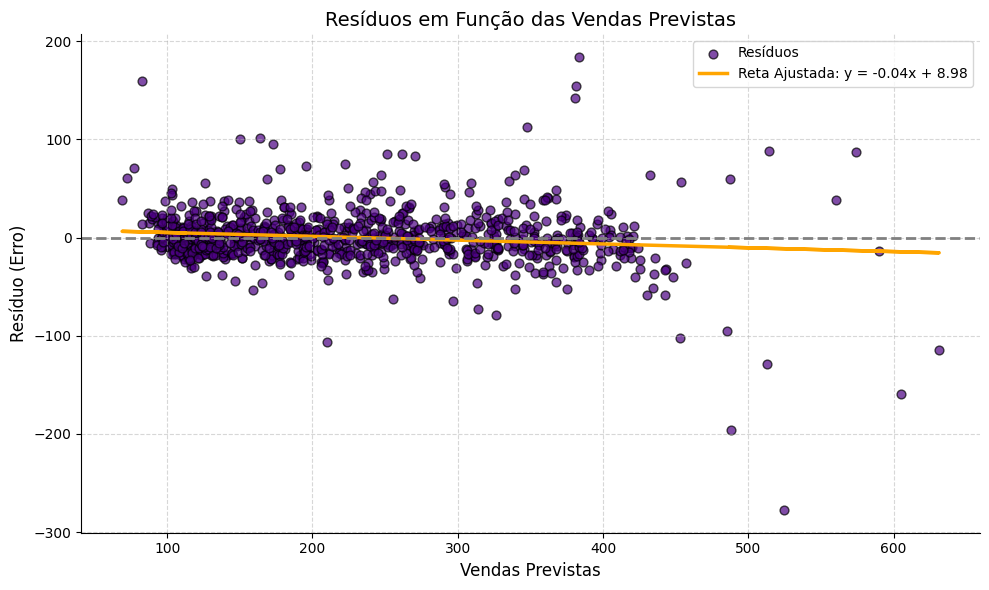

In [455]:
# @title previsto vs resíduo

# Dados
x = resultados['previsto']
y = resultados['resíduo']

# Ajuste de reta (regressão linear): y = a*x + b
a, b = np.polyfit(x, y, 1)
reta_ajustada = a * x + b

# Plotagem
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=40, alpha=0.7, color='indigo', edgecolor='black', label='Resíduos')
plt.plot(x, reta_ajustada, color='orange', linewidth=2.5, label=f'Reta Ajustada: y = {a:.2f}x + {b:.2f}')

# Linha de referência y = 0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)

# Estética e rótulos
plt.title('Resíduos em Função das Vendas Previstas', fontsize=14)
plt.xlabel('Vendas Previstas', fontsize=12)
plt.ylabel('Resíduo (Erro)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

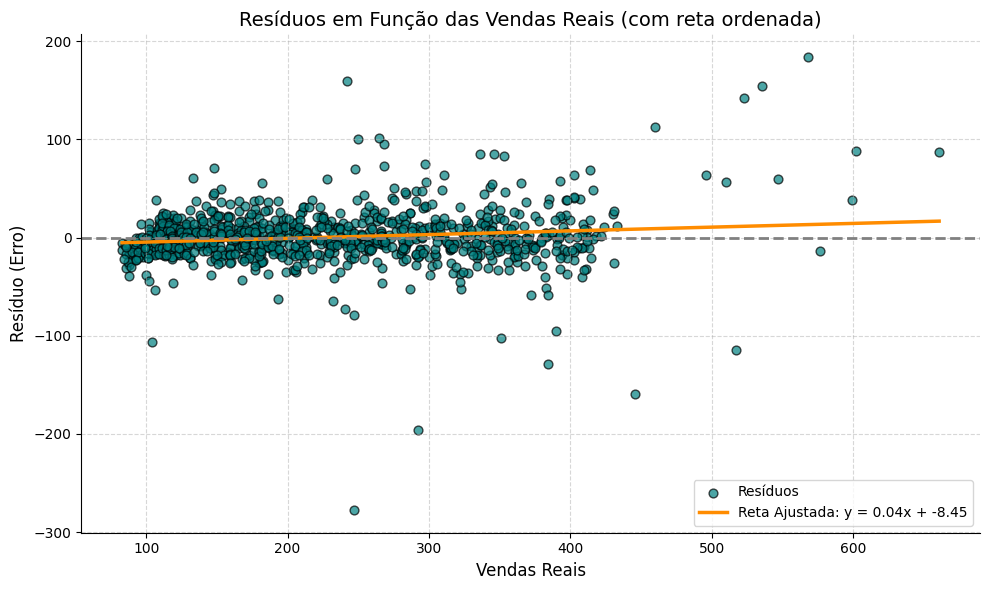

In [456]:
# @title resíduo vs r2


x = resultados['real']
y = resultados['resíduo']

# Regressão linear: reta ajustada
a, b = np.polyfit(x, y, 1)
reta = a * x + b

# Ordenar para reta contínua
ordem = np.argsort(x)
x_ord = x.iloc[ordem]
reta_ord = reta.iloc[ordem]

# Plotagem
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=40, alpha=0.7, color='teal', edgecolor='black', label='Resíduos')
plt.plot(x_ord, reta_ord, color='darkorange', linewidth=2.5, label=f'Reta Ajustada: y = {a:.2f}x + {b:.2f}')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)

# Estética
plt.title('Resíduos em Função das Vendas Reais (com reta ordenada)', fontsize=14)
plt.xlabel('Vendas Reais', fontsize=12)
plt.ylabel('Resíduo (Erro)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

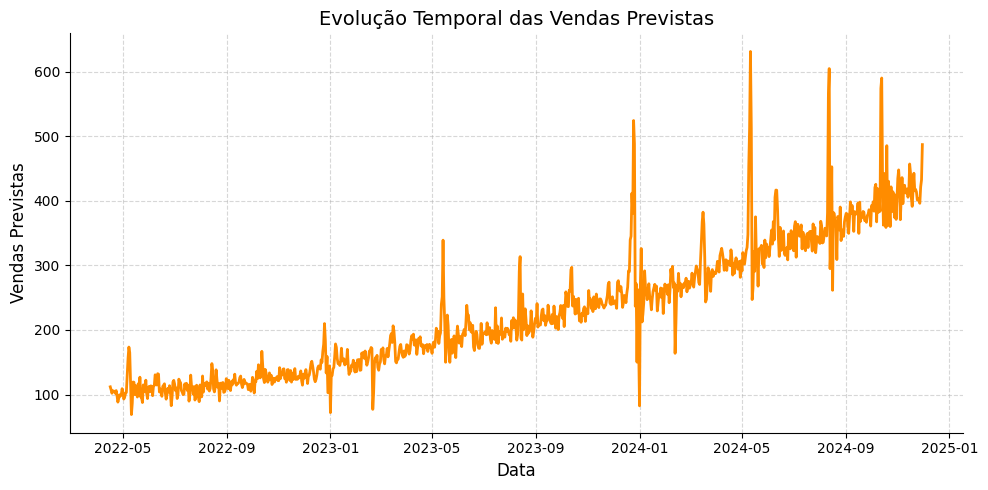

In [457]:
# @title previsto

# Plotar série temporal das previsões
plt.figure(figsize=(10, 5))
plt.plot(resultados.index, resultados['previsto'], color='darkorange', linewidth=2)

# Título e rótulos
plt.title('Evolução Temporal das Vendas Previstas', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Vendas Previstas', fontsize=12)

# Estética
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

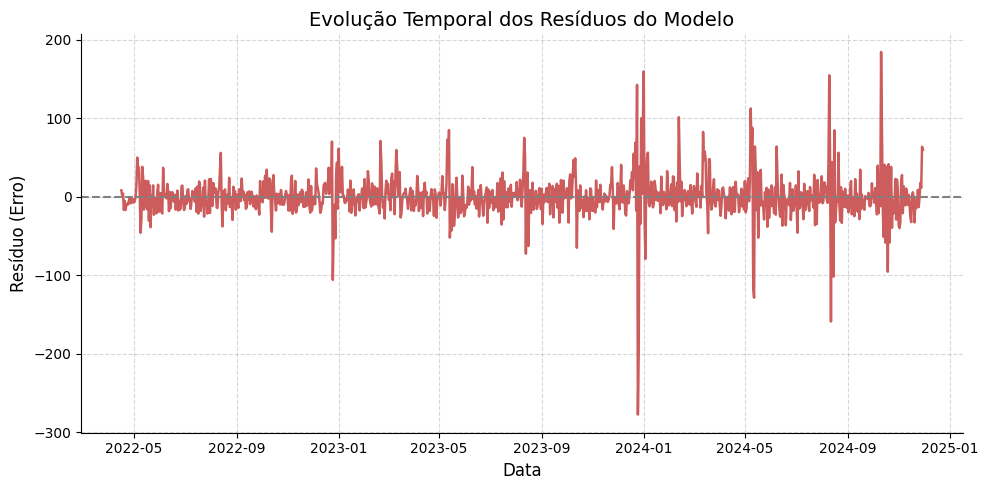

In [458]:
# @title resíduo

# Plotar série temporal dos resíduos
plt.figure(figsize=(10, 5))
plt.plot(resultados.index, resultados['resíduo'], color='indianred', linewidth=1.8)

# Linha horizontal de referência (resíduo = 0)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)

# Título e rótulos
plt.title('Evolução Temporal dos Resíduos do Modelo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Resíduo (Erro)', fontsize=12)

# Estética
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

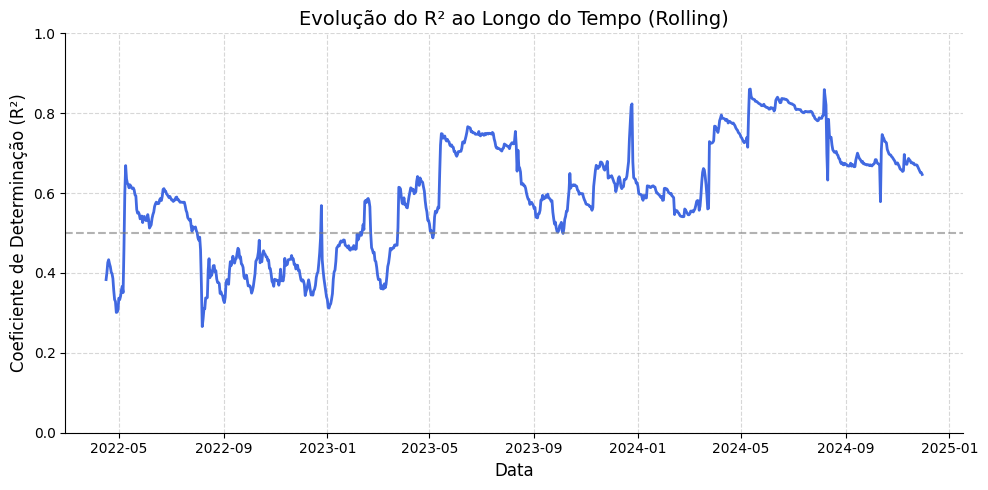

In [459]:
# @title Série temporal do R²

# Plotar série temporal do R²
plt.figure(figsize=(10, 5))
plt.plot(resultados.index, resultados['r2'], color='royalblue', linewidth=2)

# Título e rótulos
plt.title('Evolução do R² ao Longo do Tempo (Rolling)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Coeficiente de Determinação (R²)', fontsize=12)

# Linha de referência em R² = 0.5 (opcional, ponto crítico)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.6)

# Estética
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)  # Mantém a escala entre 0 e 1 (válido para R²)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

In [460]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular métricas de desempenho
rmse = np.sqrt(mean_squared_error(resultados['real'], resultados['previsto']))
mae = mean_absolute_error(resultados['real'], resultados['previsto'])
r2_medio = resultados['r2'].mean()

# Exibir resultados formatados
print(f"🔹 RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
print(f"🔹 MAE (Erro Absoluto Médio): {mae:.2f}")
print(f"🔹 R² médio (coeficiente de determinação): {r2_medio:.4f}")

🔹 RMSE (Raiz do Erro Quadrático Médio): 28.03
🔹 MAE (Erro Absoluto Médio): 17.16
🔹 R² médio (coeficiente de determinação): 0.5961


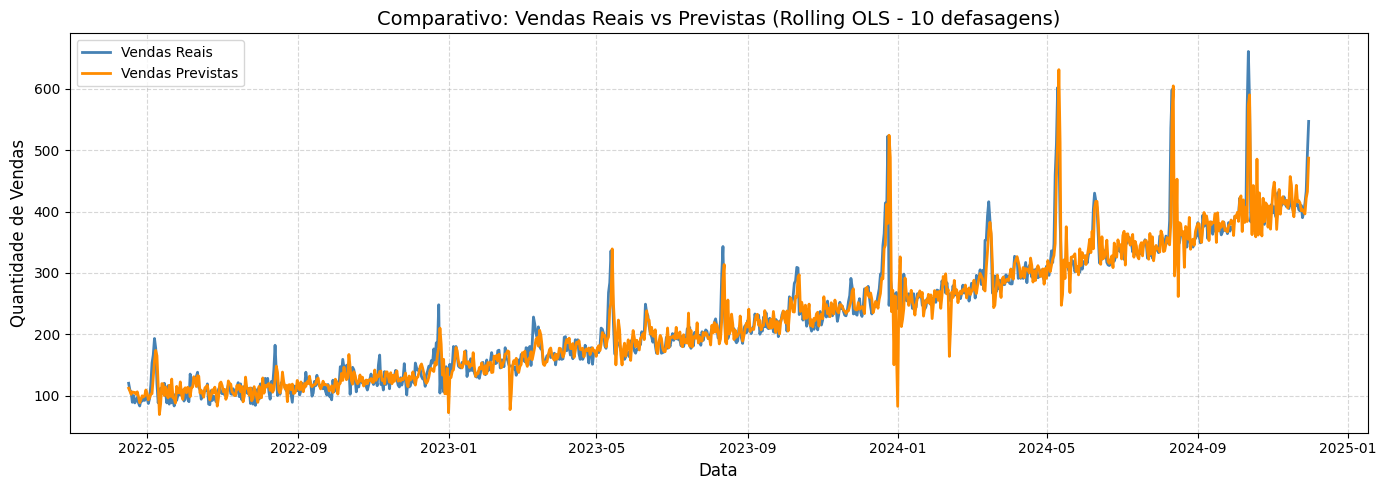

In [461]:
# @title Gráfico de linha: real vs previsto
# Gráfico de linha: real vs previsto
plt.figure(figsize=(14, 5))
plt.plot(resultados.index, resultados['real'], label='Vendas Reais', linewidth=2, color='steelblue')
plt.plot(resultados.index, resultados['previsto'], label='Vendas Previstas', linewidth=2, color='darkorange')

# Título e rótulos
plt.title('Comparativo: Vendas Reais vs Previstas (Rolling OLS - 10 defasagens)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Quantidade de Vendas', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

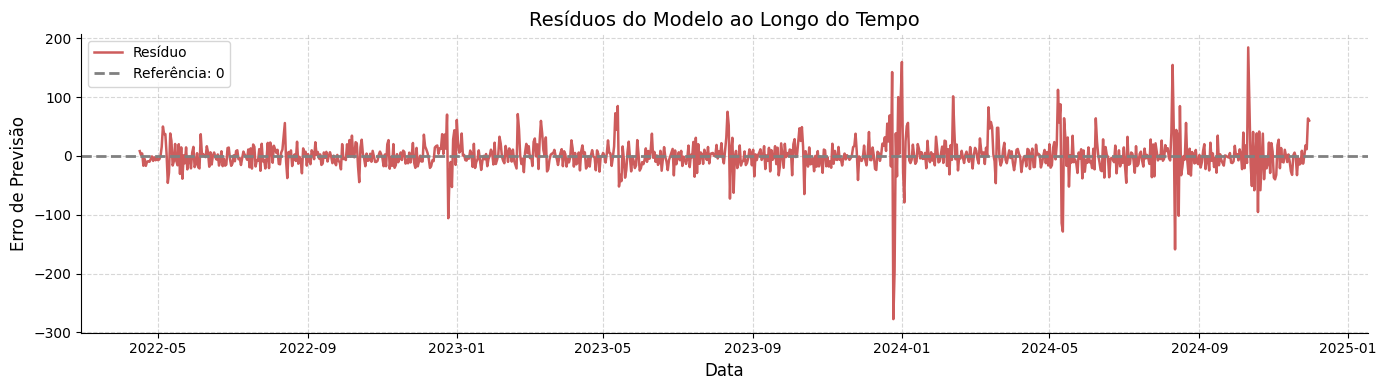

In [462]:
# @title Resíduos do Modelo ao Longo do Tempo


plt.figure(figsize=(14, 4))
plt.plot(resultados.index, resultados['resíduo'], color='indianred', linewidth=1.8, label='Resíduo')
plt.axhline(0, color='gray', linestyle='--', linewidth=2, label='Referência: 0')

# Título e rótulos
plt.title('Resíduos do Modelo ao Longo do Tempo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Erro de Previsão', fontsize=12)

# Estética
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()


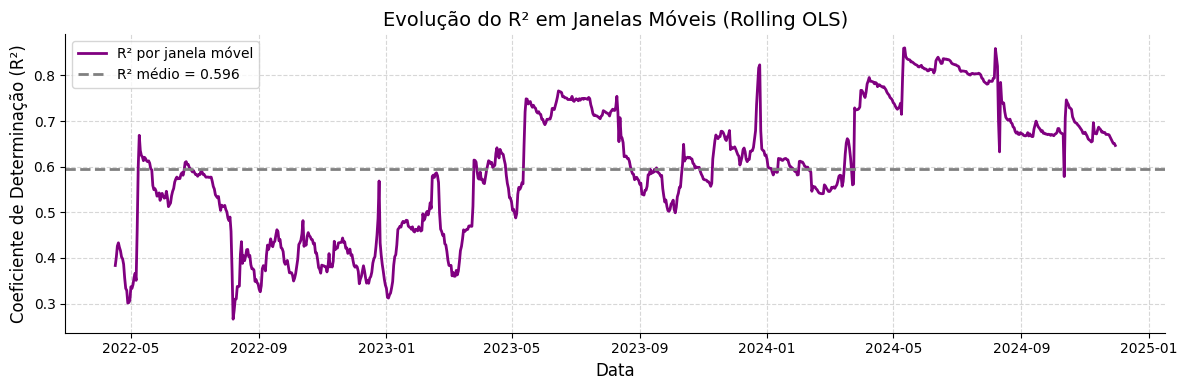

In [463]:

plt.figure(figsize=(12, 4))
plt.plot(resultados.index, resultados['r2'], color='purple', linewidth=2, label='R² por janela móvel')
plt.axhline(resultados['r2'].mean(), color='gray', linestyle='--', linewidth=2, label=f'R² médio = {resultados["r2"].mean():.3f}')

# Título e rótulos
plt.title('Evolução do R² em Janelas Móveis (Rolling OLS)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Coeficiente de Determinação (R²)', fontsize=12)

# Estética
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

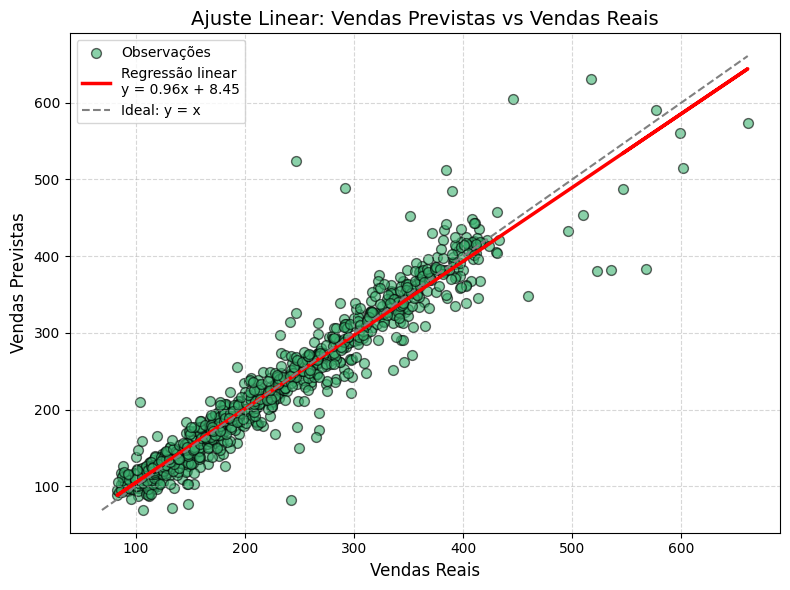

In [464]:

from scipy.stats import linregress
import matplotlib.pyplot as plt

# Definir variáveis
x = resultados['real']
y_ = resultados['previsto']

# Regressão linear
slope, intercept, r_value, p_value, std_err = linregress(x, y_)
linha_reg = slope * x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y_, alpha=0.6, s=50, edgecolor='black', color='mediumseagreen', label='Observações')
plt.plot(x, linha_reg, color='red', linewidth=2.5, label=f'Regressão linear\ny = {slope:.2f}x + {intercept:.2f}')

# Linha ideal
limite_min = min(x.min(), y_.min())
limite_max = max(x.max(), y_.max())
plt.plot([limite_min, limite_max], [limite_min, limite_max], color='gray', linestyle='--', label='Ideal: y = x')

# Estética
plt.xlabel('Vendas Reais', fontsize=12)
plt.ylabel('Vendas Previstas', fontsize=12)
plt.title('Ajuste Linear: Vendas Previstas vs Vendas Reais', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [465]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from datetime import datetime
import statsmodels.api as sm

# 1. Definir feriados nacionais fixos
class FeriadosBrasil(AbstractHolidayCalendar):
    rules = [
        Holiday('Ano Novo', month=1, day=1),
        Holiday('Tiradentes', month=4, day=21),
        Holiday('Dia do Trabalho', month=5, day=1),
        Holiday('Independência', month=9, day=7),
        Holiday('Nossa Senhora Aparecida', month=10, day=12),
        Holiday('Finados', month=11, day=2),
        Holiday('Proclamação da República', month=11, day=15),
        Holiday('Natal', month=12, day=25)
    ]

# 2. Gerar os feriados entre 2022 e 2024
feriados = FeriadosBrasil().holidays(start='2022-01-01', end='2024-12-31')

# 3. Prever para a data futura
data_futura = datetime(2024, 12, 1)
X_futuro = X.iloc[-1:].copy()  # base de estrutura

# 4. Atualizar lags com últimos valores reais de vendas
for i in range(1, 11):
    X_futuro[f'lag_{i}'] = df['vendas'].iloc[-i]

# 5. Atualizar variáveis sazonais
X_futuro['mes'] = data_futura.month
X_futuro['feriado'] = int(data_futura in feriados)

# 6. Atualizar dummies de dia da semana
for d in range(1, 7):  # assumindo dummies com drop_first=True
    X_futuro[f'dia_da_semana_{d}'] = int(data_futura.weekday() == d)

# 7. Reindexar para garantir as mesmas colunas que o modelo usou
X_futuro = sm.add_constant(X_futuro.reindex(columns=X.columns, fill_value=0))

# 8. Previsão final
previsao = modelo_final.predict(X_futuro)
print(f"📈 Previsão de vendas para {data_futura.strftime('%d/%m/%Y')}: {previsao.iloc[0]:.2f} unidades")




📈 Previsão de vendas para 01/12/2024: 524.07 unidades
